# Quantile Regression based on FCI

In [88]:
import pandas as pd
import numpy as np

#Loading data

# fci_quart_data = pd.read_pickle('fci_processed/double_pca_quart_fci.pkl')
# #changing to percentage points
# fci_quart_data = fci_quart_data.dropna(axis=0, how='any')
# fci_quart_data['quarterly_ggdp_ppp_growth_annualized'] = fci_quart_data['quarterly_ggdp_ppp_growth_annualized'] * 100

# trying fci_2
fci_quart_data = pd.read_pickle('fci_processed/double_pca_quart_fci_2.pkl')
#changing to percentage points
fci_quart_data = fci_quart_data.dropna(axis=0, how='any')
fci_quart_data['quarterly_ggdp_ppp_growth_annualized'] = fci_quart_data['quarterly_ggdp_ppp_growth_annualized'] * 100

## Does FCI Granger cause GGDP growth?
We will estimate the $ADL(h,h)$ model: $ GGDP_{t+h} = \alpha + \beta \cdot GGDP_{t} + \delta \cdot FCI_{t} $

In [89]:
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order

lag = 3
# 
# sel_res = ardl_select_order(
#     fci_quart_data['quarterly_ggdp_ppp_growth_annualized'], [1, 2, 3, 4],
#     fci_quart_data[['quarterly_ggdp_ppp_growth_annualized', 'double_pca_fci']], 4, ic="bic", trend="c", glob=True)
# 
# print(sel_res.model.ardl_order)
# print(sel_res.model.fit().summary())

adl_model = ARDL(fci_quart_data['quarterly_ggdp_ppp_growth_annualized'],
                 [lag],
                 fci_quart_data[['quarterly_ggdp_ppp_growth_annualized', 'double_pca_fci']],
                 {"double_pca_fci": [lag]})

print(adl_model.fit().summary())


                                       ARDL Model Results                                       
Dep. Variable:     quarterly_ggdp_ppp_growth_annualized   No. Observations:                  134
Model:                                       ARDL(3, 3)   Log Likelihood                -385.017
Method:                                 Conditional MLE   S.D. of innovations              4.573
Date:                                  Tue, 09 Jul 2024   AIC                            778.035
Time:                                          12:31:53   BIC                            789.535
Sample:                                      01-01-1991   HQIC                           782.708
                                           - 07-01-2023                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const   

C:\Users\yarde\anaconda3\envs\ggdp-research\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\yarde\anaconda3\envs\ggdp-research\Lib\site-packages\statsmodels\tsa\ardl\model.py:455: SpecificationWarning: exog contains variables that are missing from the order dictionary.  Missing keys: quarterly_ggdp_ppp_growth_annualized.
  return _format_order(self.data.orig_exog, order, self._causal)


In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

from quantile_regression_functions import Lag, fit_qr, estimate_quantiles, predict_quantiles

sns.set_style('white')

#creates a range from 0.05 to 0.95 with step of 0.05
quantiles = np.arange(0.05, 0.96, 0.05, dtype=float)
quantiles = np.round(quantiles, 2)

#### one quarter ahead
lag = 1
formula = f'quarterly_ggdp_ppp_growth_annualized ~ Lag(double_pca_fci, {lag})'

#estimating quantiles
qr_res_list_1, ols_model_summary_1 = estimate_quantiles(quantiles, formula, fci_quart_data)
models_summary_df_1_quart = pd.DataFrame([res.to_list() for res in qr_res_list_1], columns=['q', 'a', 'b', 'lb', 'ub'])
#predicting quantiles
# quantiles_to_predict = [0.05, 0.25, 0.5, 0.75, 0.95]


quantiles_to_predict = quantiles
q_predict_1_quart = predict_quantiles(qr_res_list_1, lag, quantiles_to_predict, fci_quart_data, 'double_pca_fci',
                                      ols_model_summary=ols_model_summary_1)
q_predict_1_quart = q_predict_1_quart.join(fci_quart_data['quarterly_ggdp_ppp_growth_annualized'])
q_predict_1_quart = q_predict_1_quart.rename(columns={'quarterly_ggdp_ppp_growth_annualized': 'realized_ggdp_growth'})

#### one year (4 quarters) ahead
lag = 4
formula = f'quarterly_ggdp_ppp_growth_annualized ~ Lag(double_pca_fci, {lag})'

#estimating quantiles
qr_res_list_4, ols_model_summary_4 = estimate_quantiles(quantiles, formula, fci_quart_data)

models_summary_df_4_quart = pd.DataFrame([res.to_list() for res in qr_res_list_4], columns=['q', 'a', 'b', 'lb', 'ub'])
#predicting quantiles
quantiles_to_predict = [0.05, 0.25, 0.5, 0.75, 0.95]
q_predict_4_quart = predict_quantiles(qr_res_list_4, lag, quantiles_to_predict, fci_quart_data, 'double_pca_fci',
                                      ols_model_summary=ols_model_summary_4)
q_predict_4_quart = q_predict_4_quart.join(fci_quart_data['quarterly_ggdp_ppp_growth_annualized'])
q_predict_4_quart = q_predict_4_quart.rename(columns={'quarterly_ggdp_ppp_growth_annualized': 'realized_ggdp_growth'})

#saving results both to pickle and to csv to be able to use in r
q_predict_1_quart.to_pickle('gar_analysis/q_predict_1_quart.pkl')
q_predict_1_quart.to_csv('gar_analysis/q_predict_1_quart.csv')
q_predict_4_quart.to_pickle('gar_analysis/q_predict_4_quart.pkl')
q_predict_4_quart.to_csv('gar_analysis/q_predict_4_quart.csv')

## trying the ADL model - consists of both GGDP and FCI lagged by 3

# lag = 3
# formula = f'quarterly_ggdp_ppp_growth_annualized ~ Lag(double_pca_fci, {lag}) + Lag(quarterly_ggdp_ppp_growth_annualized, {lag})'
# 
# #estimating quantiles
# qr_res_list_3, ols_model_summary_3 = estimate_quantiles(quantiles, formula, fci_quart_data)
# 
# models_summary_df_3_quart = pd.DataFrame([res.to_list() for res in qr_res_list_3], columns=['q', 'a', 'b', 'lb', 'ub'])
# #predicting quantiles
# quantiles_to_predict = [0.05, 0.25, 0.5, 0.75, 0.95]
# q_predict_3_quart = predict_quantiles(qr_res_list_3, lag, quantiles_to_predict, fci_quart_data, 'double_pca_fci',
#                                       ols_model_summary=ols_model_summary_3)
# q_predict_3_quart = q_predict_3_quart.join(fci_quart_data['quarterly_ggdp_ppp_growth_annualized'])
# q_predict_3_quart = q_predict_3_quart.rename(columns={'quarterly_ggdp_ppp_growth_annualized': 'realized_ggdp_growth'})

#saving results both to pickle and to csv to be able to use in r
# q_predict_1_quart.to_pickle('gar_analysis/q_predict_1_quart.pkl')
# q_predict_1_quart.to_csv('gar_analysis/q_predict_1_quart.csv')
# q_predict_4_quart.to_pickle('gar_analysis/q_predict_4_quart.pkl')
# q_predict_4_quart.to_csv('gar_analysis/q_predict_4_quart.csv')


quantile: 0.05
                                  QuantReg Regression Results                                   
Dep. Variable:     quarterly_ggdp_ppp_growth_annualized   Pseudo R-squared:               0.1159
Model:                                         QuantReg   Bandwidth:                       3.889
Method:                                   Least Squares   Sparsity:                        47.91
Date:                                  Tue, 09 Jul 2024   No. Observations:                  133
Time:                                          12:31:55   Df Residuals:                      131
                                                          Df Model:                            1
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -2.8511      0.988     -2.885      0.005      -4.806      -0.896
Lag(double_pca_fci, 1)    -2.7906

C:\Users\yarde\PycharmProjects\ggdp_research\quantile_regression_functions.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ols_model_summary = dict(a=ols_model.params[0], b=ols_model.params[1], lb=ols_ci[0], ub=ols_ci[1])


quantile: 0.7
                                  QuantReg Regression Results                                   
Dep. Variable:     quarterly_ggdp_ppp_growth_annualized   Pseudo R-squared:              0.07193
Model:                                         QuantReg   Bandwidth:                       3.247
Method:                                   Least Squares   Sparsity:                        11.11
Date:                                  Tue, 09 Jul 2024   No. Observations:                  130
Time:                                          12:31:56   Df Residuals:                      128
                                                          Df Model:                            1
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  6.2754      0.447     14.029      0.000       5.390       7.161
Lag(double_pca_fci, 4)    -1.2280 

C:\Users\yarde\PycharmProjects\ggdp_research\quantile_regression_functions.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ols_model_summary = dict(a=ols_model.params[0], b=ols_model.params[1], lb=ols_ci[0], ub=ols_ci[1])


## Testing Linear relationship hypothesis

For each quantile we will calculate using OLS the model at quantile $\tau$ : $GGDP\_Growth_{t+h}(\tau) = \alpha(\tau) + \beta(\tau) \cdot FCI_t$

By doing this we can estimate the confidence interval for the hypothesis $$H_0: \beta(\tau) = 0 \\ H_1: \beta(\tau) \neq 0$$
If $\hat{\beta(\tau)} \notin CI$ then we can reject the null of not having a linear relationship, meaning there is a non-linear relationship

In [62]:


# models_summary_df_1_quart.index = models_summary_df_1_quart['q']
# models_summary_df_4_quart.index = models_summary_df_4_quart['q']

#testing with specific lag
# 

# results = []
# quantile_names = {q: f'Q_{int(100 * q)}' for q in quantiles}
# q_predict_1_quart = q_predict_1_quart.rename(columns=quantile_names)
# models_summary_df_1_quart = models_summary_df_1_quart.rename(columns=quantile_names)
# 
# for _, q in quantile_names.items():
#     lag = 1
#     #
#     formula = f'{q} ~ Lag(double_pca_fci, {lag})'
#     ols_lag_1_model = sm.OLS.from_formula(formula, data=q_predict_1_quart).fit()
#     ols_param_names = ols_lag_1_model.params.index.to_list()
#     curr_ci = ols_lag_1_model.conf_int().loc[ols_param_names[1]].to_list()
#     results.append((curr_ci[0], curr_ci[1]))
# 
# ols_ci_df = pd.DataFrame(results, columns=['ols_lb', 'ols_ub'], index=quantiles)
# models_summary_df_1_quart = models_summary_df_1_quart.join(ols_ci_df)



## Plotting Quantile Regression Estimated Coefficients

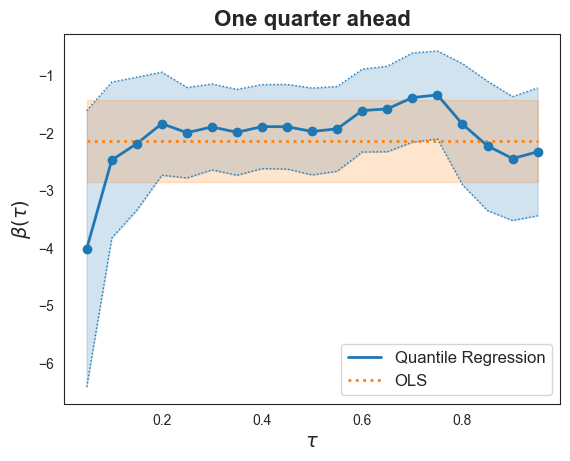

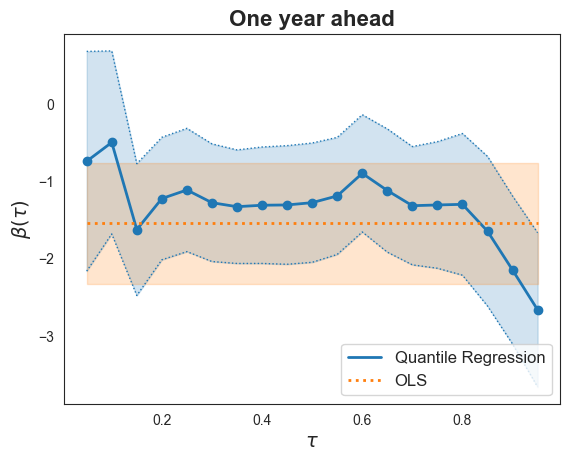

In [85]:

plt.plot(models_summary_df_1_quart.q, models_summary_df_1_quart.b, color="#1f77b4", label="Quantile Regression",
         linewidth=2)
plt.plot(models_summary_df_1_quart.q, models_summary_df_1_quart.ub, linestyle="dotted", color="#1f77b4", linewidth=1)
plt.plot(models_summary_df_1_quart.q, models_summary_df_1_quart.lb, linestyle="dotted", color="#1f77b4", linewidth=1)

# Fill the area between the upper and lower bounds of the quantile regression
plt.fill_between(models_summary_df_1_quart.q, models_summary_df_1_quart.lb, models_summary_df_1_quart.ub,
                 color='#1f77b4', alpha=0.2)

plt.scatter(models_summary_df_1_quart.q, models_summary_df_1_quart.b, color="#1f77b4", edgecolor='face', zorder=5)

# Plot OLS line and fill the confidence interval
plt.plot(models_summary_df_1_quart.q, [ols_model_summary_1["b"]] * len(models_summary_df_1_quart.q), color="#ff7f0e",
         linestyle="dotted",
         label="OLS", linewidth=2)
plt.fill_between(models_summary_df_1_quart.q, ols_model_summary_1["lb"], ols_model_summary_1["ub"], color='#ff7f0e',
                 alpha=0.2)

## Hypothesis CI
# plt.fill_between(models_summary_df_1_quart.q, models_summary_df_1_quart["ols_lb"],models_summary_df_1_quart["ols_ub"], color='#e70eff', alpha=0.2)

plt.xlabel(r"$\tau$", fontsize=14)
plt.ylabel(r"$\beta(\tau)$", fontsize=14)
plt.title("One quarter ahead", fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=12)
plt.show()

plt.plot(models_summary_df_4_quart.q, models_summary_df_4_quart.b, color="#1f77b4", label="Quantile Regression",
         linewidth=2)
plt.plot(models_summary_df_4_quart.q, models_summary_df_4_quart.ub, linestyle="dotted", color="#1f77b4", linewidth=1)
plt.plot(models_summary_df_4_quart.q, models_summary_df_4_quart.lb, linestyle="dotted", color="#1f77b4", linewidth=1)

# Fill the area between the upper and lower bounds of the quantile regression
plt.fill_between(models_summary_df_4_quart.q, models_summary_df_4_quart.lb, models_summary_df_4_quart.ub,
                 color='#1f77b4', alpha=0.2)

plt.scatter(models_summary_df_4_quart.q, models_summary_df_4_quart.b, color="#1f77b4", edgecolor='face', zorder=5)

# Plot OLS line and fill the confidence interval
plt.plot(models_summary_df_4_quart.q, [ols_model_summary_4["b"]] * len(models_summary_df_4_quart.q), color="#ff7f0e",
         linestyle="dotted",
         label="OLS", linewidth=2)
plt.fill_between(models_summary_df_4_quart.q, ols_model_summary_4["lb"], ols_model_summary_4["ub"], color='#ff7f0e',
                 alpha=0.2)

plt.xlabel(r"$\tau$", fontsize=14)
plt.ylabel(r"$\beta(\tau)$", fontsize=14)
plt.title("One year ahead", fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=12)
plt.show()



# plt.plot(models_summary_df_3_quart.q, models_summary_df_3_quart.b, color="#1f77b4", label="Quantile Regression",
#          linewidth=2)
# plt.plot(models_summary_df_3_quart.q, models_summary_df_3_quart.ub, linestyle="dotted", color="#1f77b4", linewidth=1)
# plt.plot(models_summary_df_3_quart.q, models_summary_df_3_quart.lb, linestyle="dotted", color="#1f77b4", linewidth=1)
# 
# # Fill the area between the upper and lower bounds of the quantile regression
# plt.fill_between(models_summary_df_3_quart.q, models_summary_df_3_quart.lb, models_summary_df_3_quart.ub,
#                  color='#1f77b4', alpha=0.2)
# 
# plt.scatter(models_summary_df_3_quart.q, models_summary_df_3_quart.b, color="#1f77b4", edgecolor='face', zorder=5)
# 
# # Plot OLS line and fill the confidence interval
# plt.plot(models_summary_df_3_quart.q, [ols_model_summary_3["b"]] * len(models_summary_df_3_quart.q), color="#ff7f0e",
#          linestyle="dotted",
#          label="OLS", linewidth=2)
# plt.fill_between(models_summary_df_3_quart.q, ols_model_summary_3["lb"], ols_model_summary_3["ub"], color='#ff7f0e',
#                  alpha=0.2)
# 
# plt.xlabel(r"$\tau$", fontsize=14)
# plt.ylabel(r"$\beta(\tau)$", fontsize=14)
# plt.title("One year ahead", fontsize=16, fontweight='bold')
# plt.legend(loc='lower right', fontsize=12)
# plt.show()




# Realization vs Predicted distributions

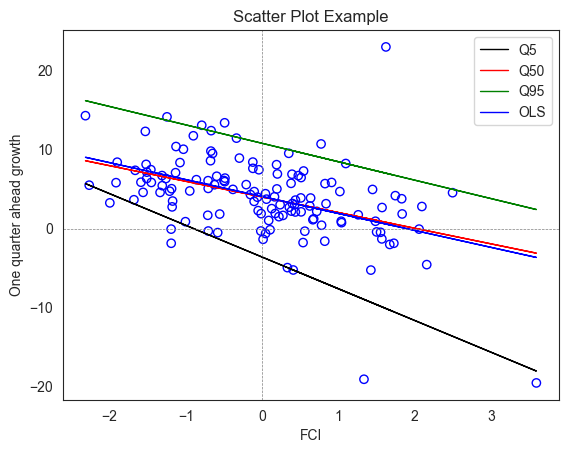

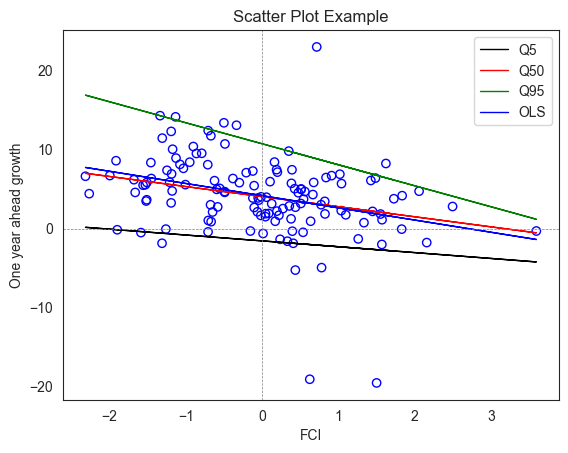

In [86]:
sns.set_style('white')

plt.scatter(q_predict_1_quart['double_pca_fci'], q_predict_1_quart['realized_ggdp_growth'], facecolors='none',
            edgecolors='b')

plt.plot(q_predict_1_quart['double_pca_fci'], q_predict_1_quart[0.05], color="black", linestyle='solid', label="Q5",
         linewidth=1)
plt.plot(q_predict_1_quart['double_pca_fci'], q_predict_1_quart[0.5], color="red", linestyle='solid', label="Q50",
         linewidth=1)
plt.plot(q_predict_1_quart['double_pca_fci'], q_predict_1_quart[0.95], color="green", linestyle='solid', label="Q95",
         linewidth=1)
plt.plot(q_predict_1_quart['double_pca_fci'], q_predict_1_quart['ols'], color="blue", linestyle='solid', label="OLS",
         linewidth=1)

plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(x=0, color='gray', linestyle='--', linewidth=0.5)

plt.title('Scatter Plot Example')
plt.xlabel('FCI')
plt.ylabel('One quarter ahead growth')
plt.legend()
plt.show()

plt.scatter(q_predict_4_quart['double_pca_fci'], q_predict_4_quart['realized_ggdp_growth'], facecolors='none',
            edgecolors='b')

plt.plot(q_predict_4_quart['double_pca_fci'], q_predict_4_quart[0.05], color="black", linestyle='solid', label="Q5",
         linewidth=1)
plt.plot(q_predict_4_quart['double_pca_fci'], q_predict_4_quart[0.5], color="red", linestyle='solid', label="Q50",
         linewidth=1)
plt.plot(q_predict_4_quart['double_pca_fci'], q_predict_4_quart[0.95], color="green", linestyle='solid', label="Q95",
         linewidth=1)
plt.plot(q_predict_4_quart['double_pca_fci'], q_predict_4_quart['ols'], color="blue", linestyle='solid', label="OLS",
         linewidth=1)

plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(x=0, color='gray', linestyle='--', linewidth=0.5)

plt.title('Scatter Plot Example')
plt.xlabel('FCI')
plt.ylabel('One year ahead growth')
plt.legend()
plt.show()

## Predicted Distributions

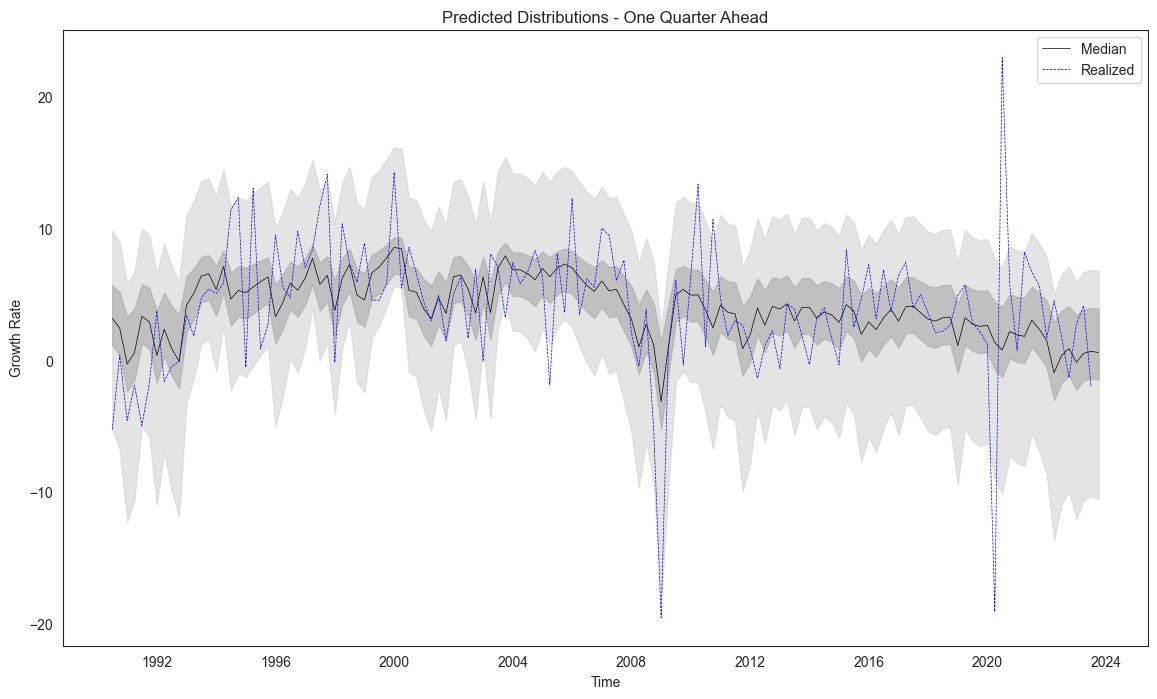

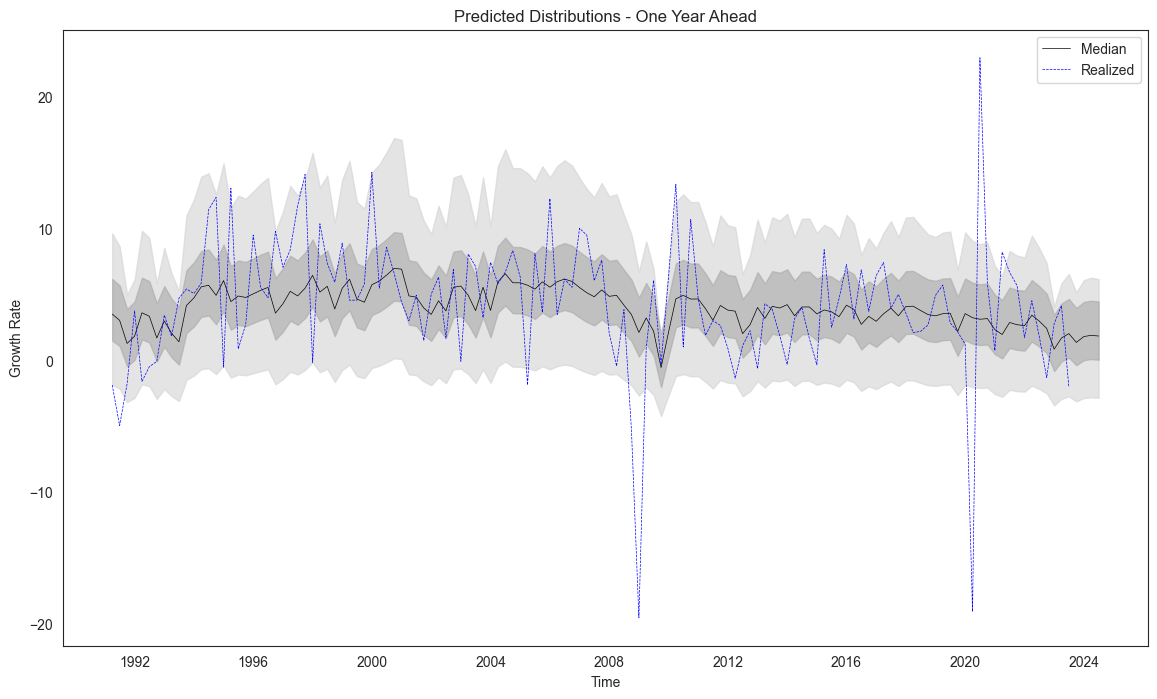

In [87]:

# 1 quarter ahead

t = q_predict_1_quart.index
plt.figure(figsize=(14, 8))
# Plot the quantiles
plt.plot(t, q_predict_1_quart[0.5], color="black", linestyle='-', label="Median", linewidth=0.5)
# Plot the realized values
plt.plot(t, q_predict_1_quart['realized_ggdp_growth'], color="blue", linestyle='--', label="Realized", linewidth=0.5)
# Fill between the quantiles
plt.fill_between(t, q_predict_1_quart[0.05], q_predict_1_quart[0.95], color="lightgrey", alpha=0.6)
plt.fill_between(t, q_predict_1_quart[0.25], q_predict_1_quart[0.75], color="darkgrey", alpha=0.6)

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Growth Rate')
plt.title('Predicted Distributions - One Quarter Ahead')
plt.legend()
plt.show()

# 1 year ahead

t = q_predict_4_quart.index
plt.figure(figsize=(14, 8))
# Plot the quantiles
plt.plot(t, q_predict_4_quart[0.5], color="black", linestyle='-', label="Median", linewidth=0.5)
# Plot the realized values
plt.plot(t, q_predict_4_quart['realized_ggdp_growth'], color="blue", linestyle='--', label="Realized", linewidth=0.5)
# Fill between the quantiles
plt.fill_between(t, q_predict_4_quart[0.05], q_predict_4_quart[0.95], color="lightgrey", alpha=0.6)
plt.fill_between(t, q_predict_4_quart[0.25], q_predict_4_quart[0.75], color="darkgrey", alpha=0.6)

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Growth Rate')
plt.title('Predicted Distributions - One Year Ahead')
plt.legend()
plt.show()


####
# 
# t = q_predict_3_quart.index
# plt.figure(figsize=(14, 8))
# # Plot the quantiles
# plt.plot(t, q_predict_3_quart[0.5], color="black", linestyle='-', label="Median", linewidth=0.5)
# # Plot the realized values
# plt.plot(t, q_predict_3_quart['realized_ggdp_growth'], color="blue", linestyle='--', label="Realized", linewidth=0.5)
# # Fill between the quantiles
# plt.fill_between(t, q_predict_3_quart[0.05], q_predict_3_quart[0.95], color="lightgrey", alpha=0.6)
# plt.fill_between(t, q_predict_3_quart[0.25], q_predict_3_quart[0.75], color="darkgrey", alpha=0.6)
# 
# # Add labels and legend
# plt.xlabel('Time')
# plt.ylabel('Growth Rate')
# plt.title('Predicted Distributions - One Year Ahead')
# plt.legend()
# plt.show()

## Fitting a skew t distribution

I used R code to fit the t distributions using an optimizer

## Plotting notable financial crises, 1 and 4 quarters ahead 

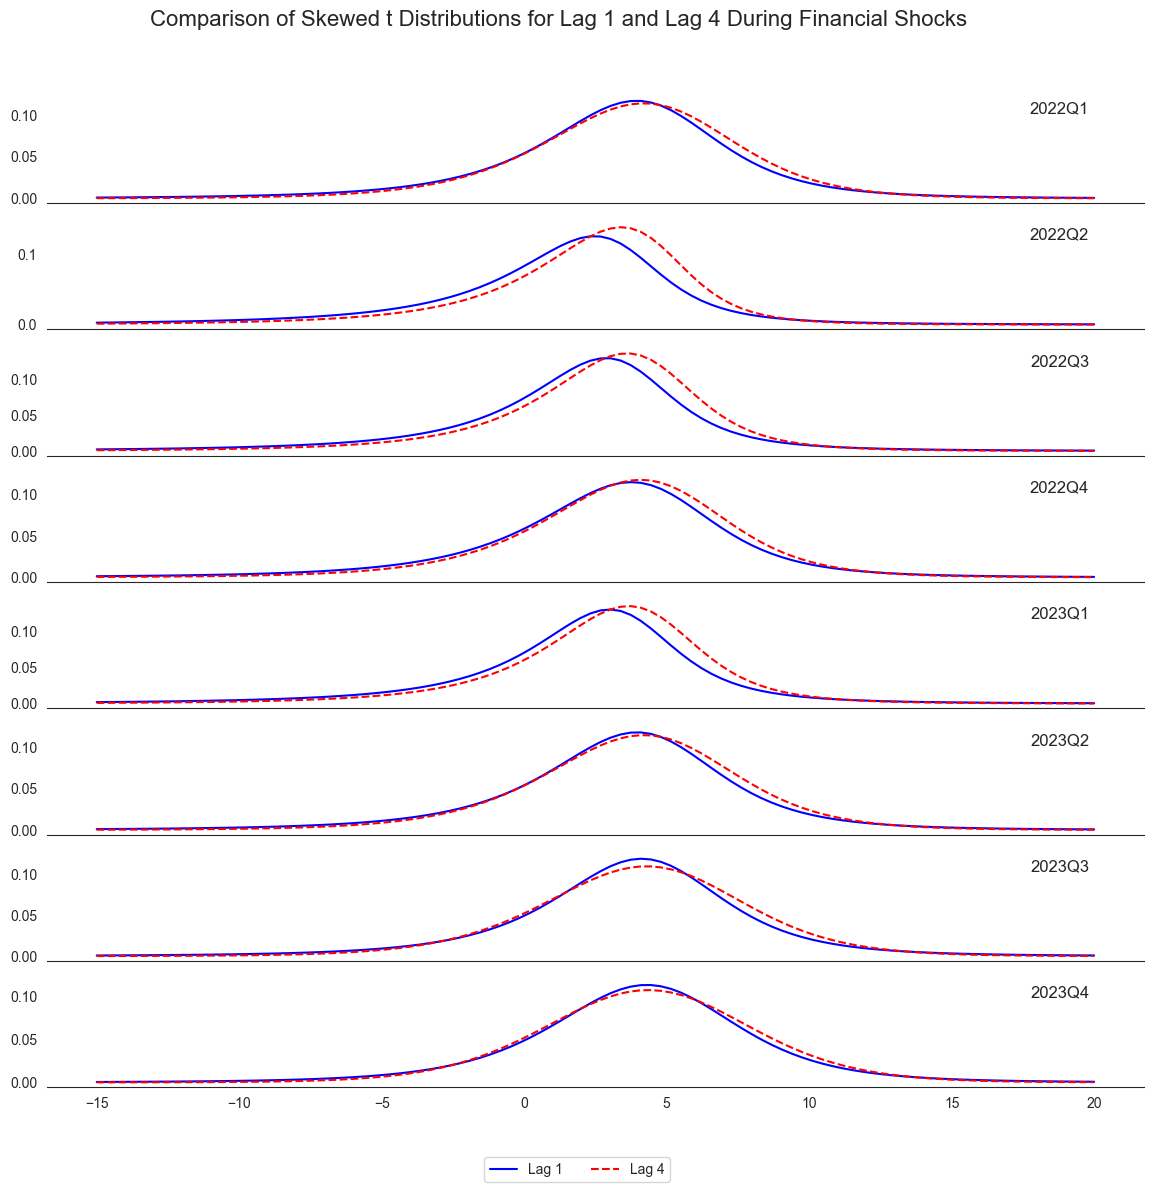

In [10]:
from skewt_scipy.skewt import skewt
import seaborn as sns

sns.set_style("white")

#Loading skewed t distribution estimates

# quantiles_to_plot = np.arange(0.05, 0.96, 0.01, dtype=float)

skew_t_dist_1_quarter = pd.read_csv('gar_analysis/skew_t_dist_1_quarter.csv')
skew_t_dist_1_quarter = skew_t_dist_1_quarter.drop(columns=['Unnamed: 0'])
skew_t_dist_1_quarter.index = pd.to_datetime(skew_t_dist_1_quarter['DATE'])

skew_t_dist_4_quarter = pd.read_csv('gar_analysis/skew_t_dist_4_quarter.csv')
skew_t_dist_4_quarter = skew_t_dist_4_quarter.drop(columns=['Unnamed: 0'])
skew_t_dist_4_quarter.index = pd.to_datetime(skew_t_dist_4_quarter['DATE'])

joint_df = skew_t_dist_4_quarter.join(skew_t_dist_1_quarter, how='left', rsuffix='_1', lsuffix='_4')


def indextime_to_year_quarter(index: pd.Timestamp):
    return f"{index.year}Q{index.quarter}"


def ridge_plot_by_date(begin: str, end: str, joint_df: pd.DataFrame):
    x = np.linspace(-15, 20, 100)
    joint_filtered = joint_df[begin:end]
    num_plots = len(joint_filtered)
    fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(12, num_plots * 1.5), sharex=True)
    # Set a nice color palette
    palette = sns.color_palette("Set2", 2)
    lag1_color = palette[0]
    lag4_color = palette[1]

    # Plotting the distributions
    for i, (index, row) in enumerate(joint_filtered.iterrows()):
        a_1, df_1, loc_1, scale_1 = row[['shape_1', 'freedom_1', 'location_1', 'scale_1']].to_numpy()
        dist_1 = skewt.pdf(x=x, a=a_1, df=df_1, loc=loc_1, scale=scale_1)

        a_4, df_4, loc_4, scale_4 = row[['shape_4', 'freedom_4', 'location_4', 'scale_4']].to_numpy()
        dist_4 = skewt.pdf(x=x, a=a_4, df=df_4, loc=loc_4, scale=scale_4)

        label = indextime_to_year_quarter(index)

        ax = axes[i]
        ax.plot(x, dist_1, label="Lag 1", color='blue')
        ax.plot(x, dist_4, label="Lag 4", color='red', linestyle='dashed')
        ax.text(0.95, 0.95, label, transform=ax.transAxes, fontsize=12, va='top', ha='right')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)

    # Add common labels
    #fig.text(0.5, 0.04, 'Value', ha='center', fontsize=14)
    #fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=14)
    fig.suptitle('Comparison of Skewed t Distributions for Lag 1 and Lag 4 During Financial Shocks', fontsize=16)

    # Add legend outside the plot
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=2)

    # Adjust layout
    plt.tight_layout(rect=[0.03, 0.05, 1, 0.95])
    plt.show()


#2008 GFC
#ridge_plot_by_date('2008-01-01', '2010-01-01', joint_df)

#2020 COVID
#ridge_plot_by_date('2020-01-01', '2021-01-01', joint_df)


#Russia-Ukraine War
# Started in Feb 2022
ridge_plot_by_date('2022-01-01', '2024-01-01', joint_df)


## Heavy tail analysis

Analysing heavy tails around financial events

We want to analyze the tail index based on the hill estimate


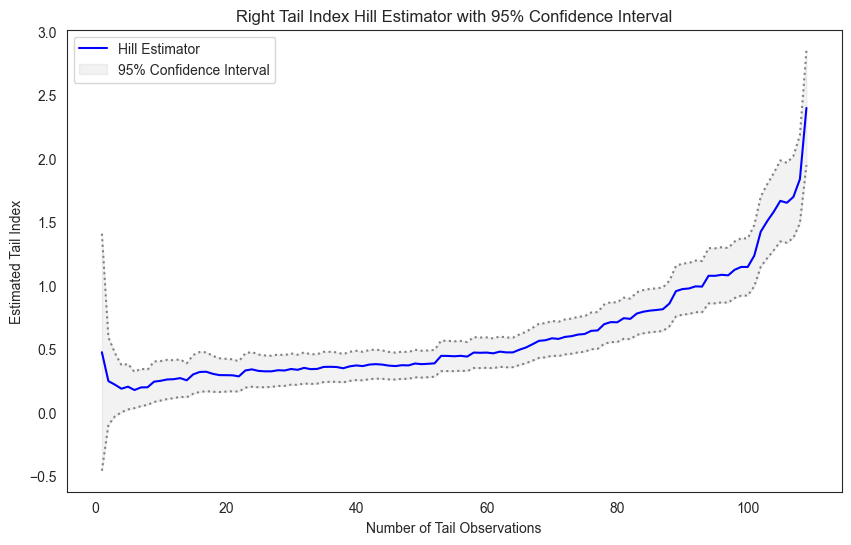

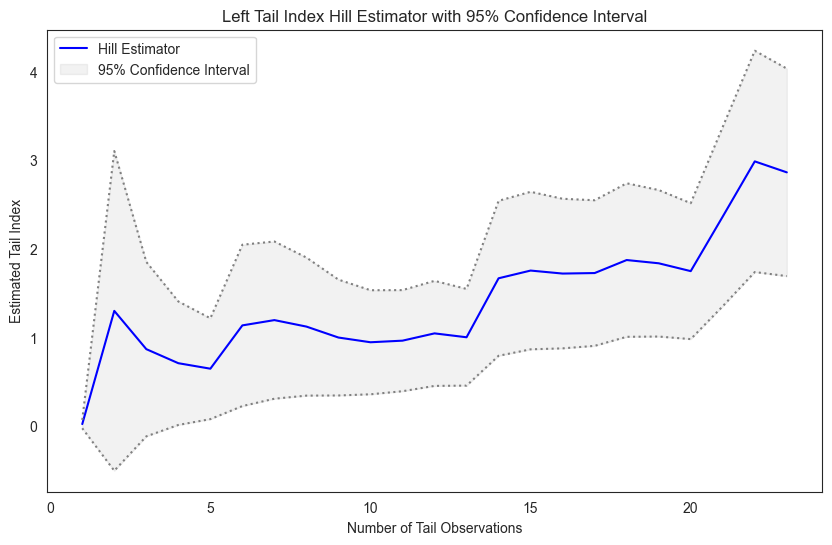

In [9]:
from heavy_tails_functions import HillEstimator

# 
from evt.estimators.hill import Hill
from evt.methods.peaks_over_threshold import PeaksOverThreshold
from evt.dataset import Dataset

# Data that I'm using
#fci_quart_data

#shifting data

#we're looking at negative growth
#we want to estimate the left tail index

ggdp_growth_series = fci_quart_data['quarterly_ggdp_ppp_growth_annualized']
ggdp_growth_series = ggdp_growth_series.rename('ggdp_growth')

#how many observations do we have with negative growth
right_threshold = 0
right_hills_estimator = HillEstimator(ggdp_growth_series, tail='right')
estimator_df = right_hills_estimator.estimate_hill_statistic(threshold=right_threshold)

plt.figure(figsize=(10, 6))
plt.plot(estimator_df['num_tail_observations'], estimator_df['estimate'], label='Hill Estimator', color='blue')
plt.plot(estimator_df['num_tail_observations'], estimator_df['ci_lower'], color='gray',
         linestyle='dotted')
plt.plot(estimator_df['num_tail_observations'], estimator_df['ci_upper'], color='grey',
         linestyle='dotted')

plt.fill_between(estimator_df['num_tail_observations'], estimator_df['ci_lower'], estimator_df['ci_upper'],
                 color="gray", alpha=0.1, label='95% Confidence Interval')

plt.title('Right Tail Index Hill Estimator with 95% Confidence Interval')
plt.xlabel('Number of Tail Observations')
plt.ylabel('Estimated Tail Index')

# Adding a legend
plt.legend(loc='best')
plt.show()

#Left tail 
left_threshold = 0
right_hills_estimator = HillEstimator(ggdp_growth_series, tail='left')
estimator_df = right_hills_estimator.estimate_hill_statistic(threshold=left_threshold)

plt.figure(figsize=(10, 6))
plt.plot(estimator_df['num_tail_observations'], estimator_df['estimate'], label='Hill Estimator', color='blue')
plt.plot(estimator_df['num_tail_observations'], estimator_df['ci_lower'], color='gray',
         linestyle='dotted')
plt.plot(estimator_df['num_tail_observations'], estimator_df['ci_upper'], color='grey',
         linestyle='dotted')

plt.fill_between(estimator_df['num_tail_observations'], estimator_df['ci_lower'], estimator_df['ci_upper'],
                 color="gray", alpha=0.1, label='95% Confidence Interval')

plt.title('Left Tail Index Hill Estimator with 95% Confidence Interval')
plt.xlabel('Number of Tail Observations')
plt.ylabel('Estimated Tail Index')

# Adding a legend
plt.legend(loc='best')
plt.show()

